In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pickle

# Define your Vocabulary class exactly as it was defined during training.
class Vocabulary:
    """Simple Vocabulary wrapper for mapping words to indices and vice versa."""
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        # Special tokens
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        import nltk  # Ensure nltk is imported locally in this context as well.
        return nltk.tokenize.word_tokenize(text.lower())

    def build_vocabulary(self, sentence_list):
        from collections import Counter  # Import Counter here as well
        frequencies = Counter()
        idx = 4  # Start indexing after the special tokens
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1
                # Add the word if it reaches the frequency threshold and is not already added.
                if frequencies[word] == self.freq_threshold and word not in self.stoi:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        return [self.stoi.get(word, self.stoi["<unk>"]) for word in self.tokenizer(text)]

# Define the fixed paths (update these if needed)
vocab_save_path = '/content/drive/MyDrive/vocab.pkl'

# Load the vocabulary from the pickle file.
with open(vocab_save_path, 'rb') as f:
    vocab = pickle.load(f)

print("Vocabulary loaded. Size:", len(vocab))


Mounted at /content/drive
Vocabulary loaded. Size: 2993


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the same paths used for saving.
vocab_save_path = '/content/drive/MyDrive/vocab.pkl'
checkpoint_path = '/content/drive/MyDrive/model_checkpoint.pth'

# Load the vocabulary.
with open(vocab_save_path, 'rb') as f:
    vocab = pickle.load(f)
print("Vocabulary loaded. Size:", len(vocab))

# Re-create your model architectures (make sure these classes exactly match your training code)
import torch.nn as nn
import torchvision.models as models

class EncoderCNN_Attn(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN_Attn, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]  # remove average pooling and fc layers
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))
        self.conv = nn.Conv2d(2048, embed_size, kernel_size=1)

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = self.conv(features)
        batch_size, embed_size, H, W = features.size()
        features = features.view(batch_size, embed_size, -1)
        features = features.permute(0, 2, 1)
        return features

class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim, attention_dim):
        super(Attention, self).__init__()
        self.attention_feature = nn.Linear(feature_dim, attention_dim)
        self.attention_hidden = nn.Linear(hidden_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, hidden):
        att1 = self.attention_feature(features)
        att2 = self.attention_hidden(hidden).unsqueeze(1)
        att = self.full_att(self.relu(att1 + att2)).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (features * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, attention_dim, feature_dim, num_layers=1, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(feature_dim, hidden_size, attention_dim)
        self.lstm = nn.LSTM(embed_size + feature_dim, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        batch_size = features.size(0)
        seq_length = embeddings.size(1)
        hidden_state = torch.zeros((1, batch_size, self.lstm.hidden_size), device=features.device)
        cell_state = torch.zeros((1, batch_size, self.lstm.hidden_size), device=features.device)
        outputs = []
        for t in range(seq_length):
            context, alpha = self.attention(features, hidden_state.squeeze(0))
            lstm_input = torch.cat((embeddings[:, t, :], context), dim=1).unsqueeze(1)
            out, (hidden_state, cell_state) = self.lstm(lstm_input, (hidden_state, cell_state))
            out = self.linear(self.dropout(out.squeeze(1)))
            outputs.append(out)
        outputs = torch.stack(outputs, dim=1)
        return outputs

# Set the hyperparameters (should match training)
embed_size = 256
hidden_size = 512
attention_dim = 256
vocab_size = len(vocab)

# Instantiate the models.
encoder = EncoderCNN_Attn(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, attention_dim, feature_dim=embed_size).to(device)

# Load the checkpoint.
checkpoint = torch.load(checkpoint_path, map_location=device)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
print("Model weights loaded from checkpoint.")

# You can now use the models to generate captions.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Vocabulary loaded. Size: 2993


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater

Model weights loaded from checkpoint.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Vocabulary loaded. Vocabulary size: 2993
Model checkpoint loaded.


Predicted Caption: man in a red shirt is rock climbing .


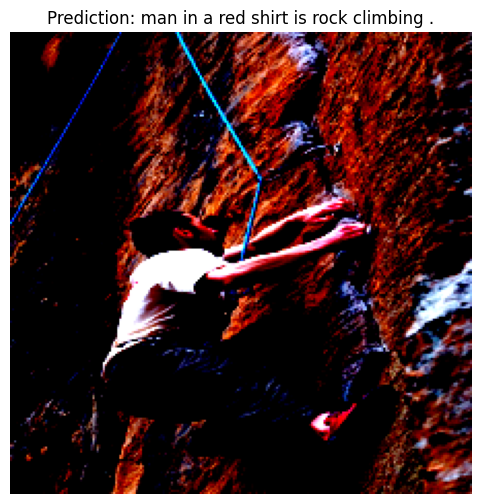

In [ ]:
# ---------------------------
# Mount Google Drive
# ---------------------------
from google.colab import drive
drive.mount('/content/drive')

# ---------------------------
# Imports and Device Setup
# ---------------------------
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# Define the Vocabulary Class
# ---------------------------
# (Must match the version used during training.)
class Vocabulary:
    """Simple Vocabulary wrapper for mapping words to indices and vice versa."""
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        # Special tokens
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        import nltk  # ensure nltk is imported locally
        return nltk.tokenize.word_tokenize(text.lower())

    def build_vocabulary(self, sentence_list):
        from collections import Counter
        frequencies = Counter()
        idx = 4  # Start indexing after special tokens
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold and word not in self.stoi:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        return [self.stoi.get(word, self.stoi["<unk>"]) for word in self.tokenizer(text)]

# ---------------------------
# Load Vocabulary from Google Drive
# ---------------------------
vocab_path = '/content/drive/MyDrive/vocab.pkl'  # Change path if necessary
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
print("Vocabulary loaded. Vocabulary size:", len(vocab))

# ---------------------------
# Define the Model Architectures
# ---------------------------
class EncoderCNN_Attn(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN_Attn, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]  # Remove pooling and fc layers
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))
        self.conv = nn.Conv2d(2048, embed_size, kernel_size=1)

    def forward(self, images):
        features = self.resnet(images)            # (batch, 2048, H, W)
        features = self.adaptive_pool(features)     # (batch, 2048, 14, 14)
        features = self.conv(features)              # (batch, embed_size, 14, 14)
        batch_size, embed_size, H, W = features.size()
        features = features.view(batch_size, embed_size, -1)  # (batch, embed_size, 196)
        features = features.permute(0, 2, 1)          # (batch, 196, embed_size)
        return features

class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim, attention_dim):
        super(Attention, self).__init__()
        self.attention_feature = nn.Linear(feature_dim, attention_dim)
        self.attention_hidden = nn.Linear(hidden_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, hidden):
        att1 = self.attention_feature(features)         # (batch, num_features, attention_dim)
        att2 = self.attention_hidden(hidden).unsqueeze(1) # (batch, 1, attention_dim)
        att = self.full_att(self.relu(att1 + att2)).squeeze(2)  # (batch, num_features)
        alpha = self.softmax(att)                         # (batch, num_features)
        attention_weighted_encoding = (features * alpha.unsqueeze(2)).sum(dim=1)  # (batch, feature_dim)
        return attention_weighted_encoding, alpha

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, attention_dim, feature_dim, num_layers=1, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(feature_dim, hidden_size, attention_dim)
        self.lstm = nn.LSTM(embed_size + feature_dim, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, captions):
        embeddings = self.embed(captions)   # (batch, seq_len, embed_size)
        batch_size = features.size(0)
        seq_length = embeddings.size(1)
        hidden_state = torch.zeros((1, batch_size, self.lstm.hidden_size), device=features.device)
        cell_state = torch.zeros((1, batch_size, self.lstm.hidden_size), device=features.device)
        outputs = []
        for t in range(seq_length):
            context, alpha = self.attention(features, hidden_state.squeeze(0))
            lstm_input = torch.cat((embeddings[:, t, :], context), dim=1).unsqueeze(1)
            out, (hidden_state, cell_state) = self.lstm(lstm_input, (hidden_state, cell_state))
            out = self.linear(self.dropout(out.squeeze(1)))
            outputs.append(out)
        outputs = torch.stack(outputs, dim=1)  # (batch, seq_length, vocab_size)
        return outputs

# ---------------------------
# Instantiate Models and Load Checkpoint
# ---------------------------
# These hyperparameters must match what you used during training.
embed_size = 256
hidden_size = 512
attention_dim = 256
vocab_size = len(vocab)

encoder = EncoderCNN_Attn(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, attention_dim, feature_dim=embed_size).to(device)

checkpoint_path = '/content/drive/MyDrive/model_checkpoint.pth'  # Change path if needed
checkpoint = torch.load(checkpoint_path, map_location=device)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
print("Model checkpoint loaded.")

# ---------------------------
# Define the Caption Generation Function
# ---------------------------
def generate_caption_beam_search(encoder, decoder, image, vocab, beam_size=3, max_length=20):
    """
    Generates a caption for a given image using beam search decoding.

    Args:
      encoder: Trained encoder model.
      decoder: Trained decoder model.
      image: A single image tensor of shape (3, H, W).
      vocab: Vocabulary object for converting indices to words.
      beam_size: Number of candidate beams to keep at each step.
      max_length: Maximum number of words in the generated caption.

    Returns:
      The generated caption as a string.
    """
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Prepare image by adding batch dimension.
        image = image.to(device).unsqueeze(0)    # Shape: (1, 3, H, W)
        features = encoder(image)                # (1, num_features, embed_size)

        # Initialize the beam with a tuple containing:
        # (current sequence, cumulative log probability, hidden state, cell state)
        start_token = vocab.stoi["<start>"]
        beams = [([start_token], 0.0,
                  torch.zeros((1, 1, decoder.lstm.hidden_size), device=device),
                  torch.zeros((1, 1, decoder.lstm.hidden_size), device=device))]

        # Beam search loop for up to max_length steps.
        for t in range(max_length):
            new_beams = []
            for seq, cum_log_prob, hidden, cell in beams:
                # If this sequence already ended with <end>, carry it forward.
                if seq[-1] == vocab.stoi["<end>"]:
                    new_beams.append((seq, cum_log_prob, hidden, cell))
                    continue
                # Get the current token and its embedding.
                current_token = torch.tensor([seq[-1]], device=device).unsqueeze(0)  # (1, 1)
                embedding = decoder.embed(current_token)  # (1, 1, embed_size)
                # Compute the context vector using the attention mechanism.
                context, _ = decoder.attention(features, hidden.squeeze(0))  # (1, embed_size)
                # Concatenate embedding and context.
                lstm_input = torch.cat((embedding.squeeze(1), context), dim=1).unsqueeze(1)  # (1, 1, 2*embed_size)
                # Pass through the LSTM.
                out, (h_new, c_new) = decoder.lstm(lstm_input, (hidden, cell))
                # Compute output scores.
                out = decoder.linear(decoder.dropout(out.squeeze(1)))  # (1, vocab_size)
                # Get the log probabilities from softmax.
                log_probs = torch.log_softmax(out, dim=1)  # (1, vocab_size)
                # Get the top beam_size candidates.
                topk_log_probs, topk_indices = torch.topk(log_probs, beam_size, dim=1)
                topk_log_probs = topk_log_probs.squeeze(0)  # (beam_size,)
                topk_indices = topk_indices.squeeze(0)      # (beam_size,)

                # For each candidate, add the word to the sequence.
                for i in range(beam_size):
                    next_token = topk_indices[i].item()
                    new_seq = seq + [next_token]
                    new_log_prob = cum_log_prob + topk_log_probs[i].item()
                    new_beams.append((new_seq, new_log_prob, h_new, c_new))

            # Sort all new beams based on the cumulative log probability and keep the top candidates.
            new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)
            beams = new_beams[:beam_size]

        # Select the best beam: Prefer one that ends with <end> token if available.
        best_seq = None
        for seq, log_prob, _, _ in beams:
            if seq[-1] == vocab.stoi["<end>"]:
                best_seq = seq
                break
        if best_seq is None:
            best_seq = beams[0][0]

        # Remove the <start> token and any trailing <end> token.
        if best_seq[0] == vocab.stoi["<start>"]:
            best_seq = best_seq[1:]
        if best_seq and best_seq[-1] == vocab.stoi["<end>"]:
            best_seq = best_seq[:-1]

        # Convert indices to words to form the caption.
        caption = " ".join([vocab.itos[idx] for idx in best_seq])
        return caption


# ---------------------------
# Sample Usage: Generate a Caption for a Sample Image
# ---------------------------
# Define the image transformations (must match training transformations).
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Specify the path to a sample image in your Google Drive.
# Update this path to point to an image file you want to test.
sample_image_path = '1.jpg'
sample_image = Image.open(sample_image_path).convert("RGB")
sample_image = transform(sample_image)

predicted_caption = generate_caption_beam_search(encoder, decoder, sample_image, vocab)
print("Predicted Caption:", predicted_caption)

# Optionally, display the image along with the predicted caption.
plt.figure(figsize=(8, 6))
plt.imshow(np.transpose(sample_image.cpu().numpy(), (1, 2, 0)))
plt.title("Prediction: " + predicted_caption)
plt.axis("off")
plt.show()
